In [1]:
import pickle
import numpy as np
with open('structured_abstract_sections.pkl', 'rb') as f:
    normalized_sections = pickle.load(f)

sentences = []
indices = []
for normal_sect in normalized_sections:
    print(f'{normal_sect}: {len(normalized_sections[normal_sect])}')
    index = [len(sentences)]
    sentences += normalized_sections[normal_sect]
    index.append(len(sentences))
    indices.append(index)
    
labels = np.zeros(indices[-1][1], dtype=int)  # 創建一個與最大索引一致的 0 陣列

# 根據 indices 填充標籤
for i, (start, end) in enumerate(indices):
    labels[start:end] = i


methods: 1492
background: 215
results: 314
conclusions: 488
objective: 523


In [2]:
from collections import defaultdict
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
import pandas

fine_tuned_model = SentenceTransformer("models/fine_tuned_sentence_bert_model_ContrastiveLoss")

# 測試新模型
embeddings = fine_tuned_model.encode(sentences)


In [3]:
embeddings.shape

(3032, 384)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np

# 1. 定義 PyTorch Dataset，先 shuffle 再存入
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        embeddings = np.array(embeddings, dtype=np.float32)
        labels = np.array(labels, dtype=np.longlong)

        # 先隨機打亂索引
        indices = np.arange(len(labels))
        np.random.shuffle(indices)

        # 根據打亂的索引重新排列 embeddings 和 labels
        self.embeddings = torch.tensor(embeddings[indices], dtype=torch.float32)
        self.labels = torch.tensor(labels[indices], dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [5]:
# 2. 定義分類模型
class Classifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 128)  # 隱藏層 128 維
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)  # 輸出層
        self.softmax = nn.LogSoftmax(dim=1)  # 可改用 CrossEntropyLoss 不需明確 softmax

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x  # CrossEntropyLoss 會處理 softmax，所以這裡不需 softmax

In [6]:
# 3. 創建 Dataset & DataLoader
from tqdm import tqdm
def train_model(train_loader, model, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epochs):
        print(f'epoch {epoch}:')
        total_loss = 0
        for batch_embeddings, batch_labels in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(batch_embeddings)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

    return model

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

def evaluate_model(test_loader, model, num_classes):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for batch_embeddings, batch_labels in test_loader:
            outputs = model(batch_embeddings)  # 模型輸出 logits
            probabilities = torch.softmax(outputs, dim=1)  # 轉為機率分佈
            predictions = torch.argmax(outputs, dim=1)  # 取得預測類別

            all_labels.extend(batch_labels.cpu().numpy())  # 轉回 NumPy
            all_predictions.extend(predictions.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())  # 機率值

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)

    # **計算 Accuracy, Precision, Recall, F1-score**
    accuracy = np.mean(all_predictions == all_labels)
    precision = precision_score(all_labels, all_predictions, average="weighted")
    recall = recall_score(all_labels, all_predictions, average="weighted")
    f1 = f1_score(all_labels, all_predictions, average="weighted")

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # **計算 ROC 曲線**
    all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # **繪製多類別 ROC Curve**
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], "k--")  # 隨機分類器
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multi-class ROC Curve")
    plt.legend()
    plt.show()

    return accuracy, precision, recall, f1


epoch 0:


100%|██████████| 86/86 [00:00<00:00, 743.99it/s]


Epoch 1/10, Loss: 63.3266
epoch 1:


100%|██████████| 86/86 [00:00<00:00, 800.74it/s]


Epoch 2/10, Loss: 4.0911
epoch 2:


100%|██████████| 86/86 [00:00<00:00, 780.47it/s]


Epoch 3/10, Loss: 0.9724
epoch 3:


100%|██████████| 86/86 [00:00<00:00, 758.02it/s]


Epoch 4/10, Loss: 0.4694
epoch 4:


100%|██████████| 86/86 [00:00<00:00, 868.10it/s]


Epoch 5/10, Loss: 0.2836
epoch 5:


100%|██████████| 86/86 [00:00<00:00, 881.74it/s]


Epoch 6/10, Loss: 0.1926
epoch 6:


100%|██████████| 86/86 [00:00<00:00, 874.03it/s]


Epoch 7/10, Loss: 0.1394
epoch 7:


100%|██████████| 86/86 [00:00<00:00, 861.22it/s]


Epoch 8/10, Loss: 0.1059
epoch 8:


100%|██████████| 86/86 [00:00<00:00, 816.30it/s]


Epoch 9/10, Loss: 0.0831
epoch 9:


100%|██████████| 86/86 [00:00<00:00, 825.59it/s]


Epoch 10/10, Loss: 0.0671
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000


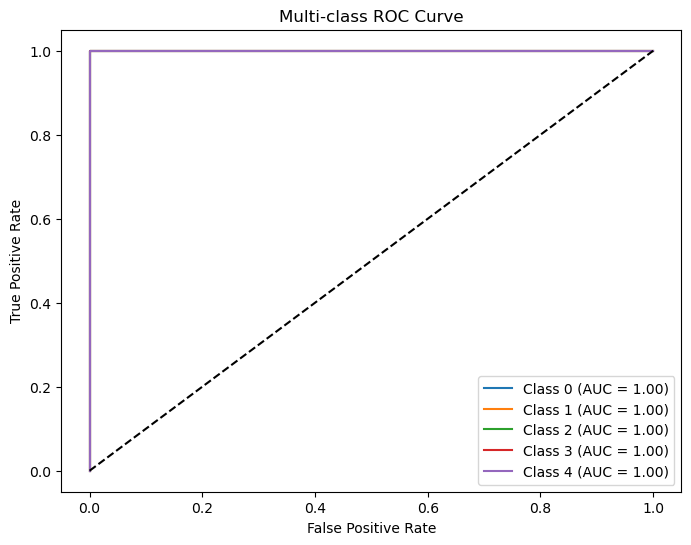

(1.0, 1.0, 1.0, 1.0)

In [11]:
from sklearn.model_selection import train_test_split

num_samples = embeddings.shape[0]
embedding_dim = embeddings.shape[1]
num_classes = 5

train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(
    embeddings, labels, test_size=0.1, random_state=42, shuffle=True
)

# 7. 創建 PyTorch Dataset & DataLoader
train_dataset = EmbeddingDataset(train_embeddings, train_labels)
test_dataset = EmbeddingDataset(test_embeddings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# 8. 初始化並訓練模型
model = Classifier(embedding_dim, num_classes)
trained_model = train_model(train_loader, model)

# 9. 測試模型
evaluate_model(test_loader, trained_model, num_classes)


In [ ]:
# dataset = EmbeddingDataset(embeddings, labels)
# loader = DataLoader(dataset, batch_size=32, shuffle=True)

# model = Classifier(embedding_dim, num_classes)
# trained_model = train_model(loader, model)

# torch.save(model, "classifier_model.pth")  # 或者用 .pt
